<a href="https://www.kaggle.com/code/tomkarlsson/playground-s04e03-001?scriptVersionId=165061842" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

In [3]:
# Display
print(f'train_data.shape: {train_data.shape:}, test_data.shape{test_data.shape}')
print(f'Number of dtypes: {pd.unique(train_data.dtypes)}')
print(f'Number of NA values: {train_data.isna().sum().sum()}')

train_data.shape: (19219, 34), test_data.shape(12814, 27)
Number of dtypes: [dtype('int64') dtype('float64')]
Number of NA values: 0


In [4]:
# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
prediction_categories
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

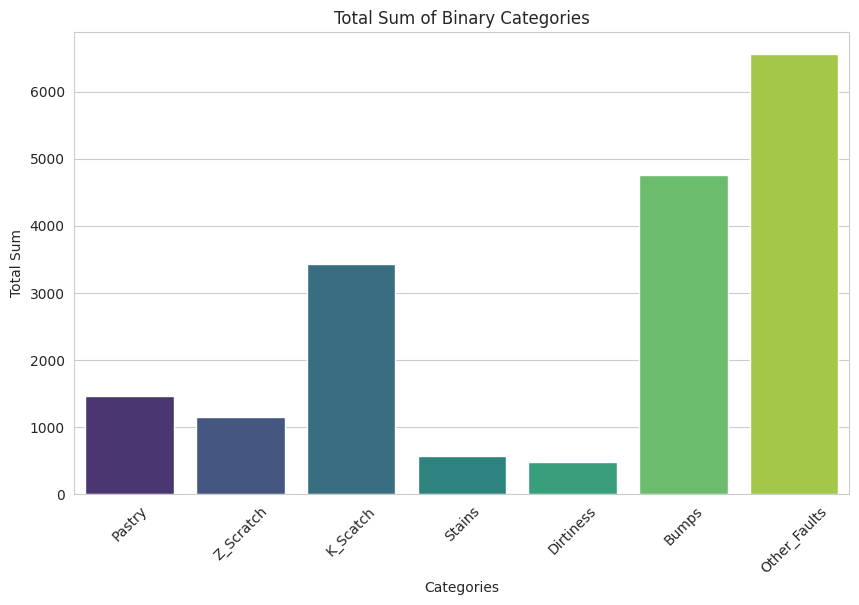

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Check
#sns.countplot(data=y_full)

# Calculate the total sum for each category (column)
totals = np.array(y_full.sum())

# Get the column names (categories)
categories = np.array(y_full.columns)

# Create a bar plot using seaborn
sns.set_style("whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size

# Create the bar plot
sns.barplot(x=categories, y=totals, palette="viridis")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Total Sum")
plt.title("Total Sum of Binary Categories")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()

**Note:** We can see that our training data is unbalanced.

# Vanilla NN
I will start by creating a NN model using default values. It will provide the base result upon which we can try to improve later on. 

In [6]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

# Create a Sequential model
model = Sequential([
    Dense(num_features, activation='relu', input_shape=(num_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
              metrics=['accuracy','auc'])

# Name the model
model.name = 'Vanilla'
# Print model summary
model.summary()

2024-03-01 22:10:52.815817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 22:10:52.815937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 22:10:52.978162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Vanilla"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 27)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,859 (18.98 KB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20, 
                               min_delta=0.001,
                               restore_best_weights=True,
                               verbose=1,
                              )

history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2663 - auc: 0.5769 - loss: 101739.4688 - val_accuracy: 0.3712 - val_auc: 0.6430 - val_loss: 23481.3809
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3521 - auc: 0.6270 - loss: 20655.3828 - val_accuracy: 0.2862 - val_auc: 0.5798 - val_loss: 9117.2510
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3702 - auc: 0.6375 - loss: 7562.5469 - val_accuracy: 0.2518 - val_auc: 0.5476 - val_loss: 5001.0254
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3522 - auc: 0.6253 - loss: 4321.9990 - val_accuracy: 0.4316 - val_auc: 0.6795 - val_loss: 6221.8809
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3568 - auc: 0.6317 - loss: 4271.2124 - val_accuracy: 0.1891 - val_auc: 0.5321 - val_loss: 1973.6078
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3473 - auc: 0.6265 - loss: 2686.0051 - val_accuracy: 0.3892 - val_auc: 0.6539 - val_loss: 2019.5054
Epoch

<Axes: title={'center': 'AUC'}>

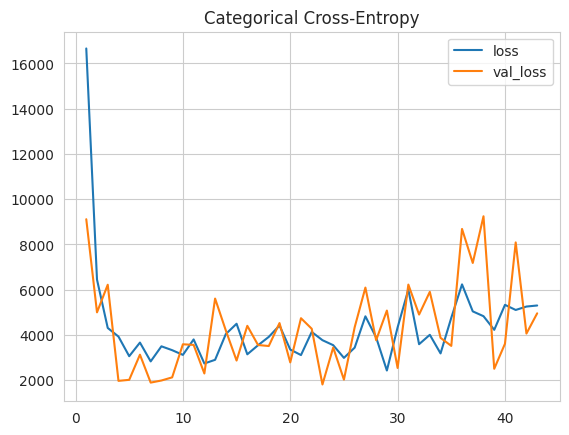

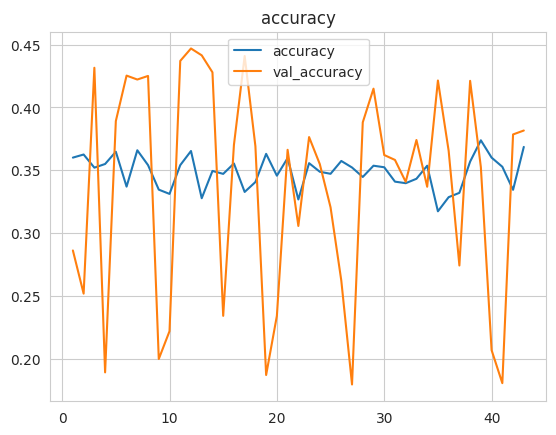

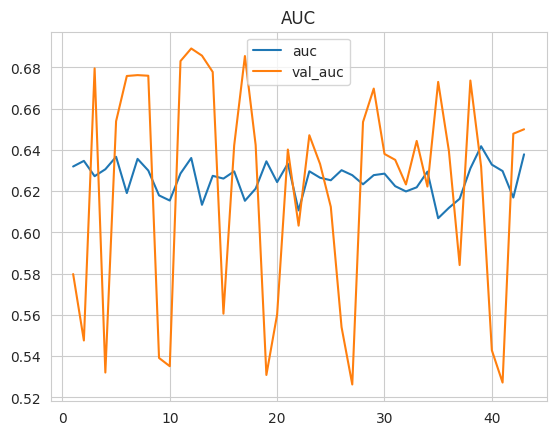

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot(title="Categorical Cross-Entropy")
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot(title="accuracy")
history_df.loc[1:, ['auc', 'val_auc']].plot(title="AUC")

In [10]:
idx = np.argmin(history.history['val_loss'])
print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
print(f'Best validation auc     : {history.history["auc"][idx]}')
print(f'Best validation loss    : {history.history["val_loss"][idx]}')

Best validation accuracy: 0.37643080949783325
Best validation auc     : 0.6296513676643372
Best validation loss    : 1813.9388427734375


## Conclusion
Our accuracy is quite low. There is definitely room for improvment.

In [11]:
# Train and submit
y_hat = model.predict(test_data)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [12]:
output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_vanilla_001.csv', index=True)

       Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
id                                                                        
19219     0.0        0.0       0.0     0.0        0.0    1.0  0.000000e+00
19220     0.0        0.0       1.0     0.0        0.0    0.0  9.335182e-17
19221     0.0        0.0       1.0     0.0        0.0    0.0  0.000000e+00
19222     0.0        0.0       0.0     0.0        0.0    1.0  1.142405e-24
19223     0.0        0.0       0.0     0.0        0.0    1.0  0.000000e+00
